In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mysg # Tom Robitaille's YSO grid tool
from astropy.table import Table
from astropy import table

from astropy.io import fits
from astropy import units as u, constants
import pylab as pl
import requests


from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, atmo_model, molecule_data
del molecule_data['h2o_b']

from astropy.visualization import simple_norm


In [2]:
D = 20*u.cm 
wavelength1 = 0.75*u.micron
resolution1 = 1.22*wavelength1/D
resolution1 = resolution1.to(u.arcsec, equivalencies=u.dimensionless_angles())
print(resolution1)

wavelength2 = 5*u.micron#
resolution2 = 1.22*wavelength2/D
resolution2 = resolution2.to(u.arcsec, equivalencies=u.dimensionless_angles())
print(resolution2)

D = 0.85*u.m 
wavelength3 = 0.75*u.micron
resolution3 = 1.22*wavelength3/D
resolution3 = resolution3.to(u.arcsec, equivalencies=u.dimensionless_angles())
print(resolution3)

wavelength4 = 5*u.micron#
resolution4 = 1.22*wavelength4/D
resolution4 = resolution4.to(u.arcsec, equivalencies=u.dimensionless_angles())
print(resolution4)

print(resolution1/resolution3, resolution2/resolution4)

0.9436614885804658 arcsec
6.291076590536439 arcsec
0.22203799731305082 arcsec
1.4802533154203383 arcsec
4.249999999999999 4.250000000000001


In [3]:
cd ../smart-plotters

/blue/adamginsburg/savannahgramze/cloudc/smart-plotters/smart-plotters


In [4]:
from jwst_plots import JWSTCatalog, make_cat_use
from glimpse_plots import GlimpseCatalog
from cutout_plot import Cutout

In [5]:
cd ../notebooks

/blue/adamginsburg/savannahgramze/cloudc/smart-plotters/notebooks


In [6]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg
from dust_extinction.parameter_averages import CCM89
from astroquery.svo_fps import SvoFps


# Filter Abs

In [7]:
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

gfilts = SvoFps.get_filter_list('Spitzer')
gfilts.add_index('filterID')

mfilts = SvoFps.get_filter_list('2MASS')
mfilts.add_index('filterID')

combined_filters = table.vstack([jfilts, gfilts, mfilts])
combined_filters.add_index('filterID')

In [8]:
instrument = 'NIRCam'
telescope = 'JWST'
filt466 = 'F466N'
#filt470 = 'F470N'
wavelength_table_466 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt466}')
#wavelength_table_470 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt470}')
wavelength_table_410 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.F410M')
wavelength_table_405 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.F405N')

wavelength_tables_jwst = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['F466N', 'F410M', 'F405N']}

Text(0, 0.5, 'Transmission')

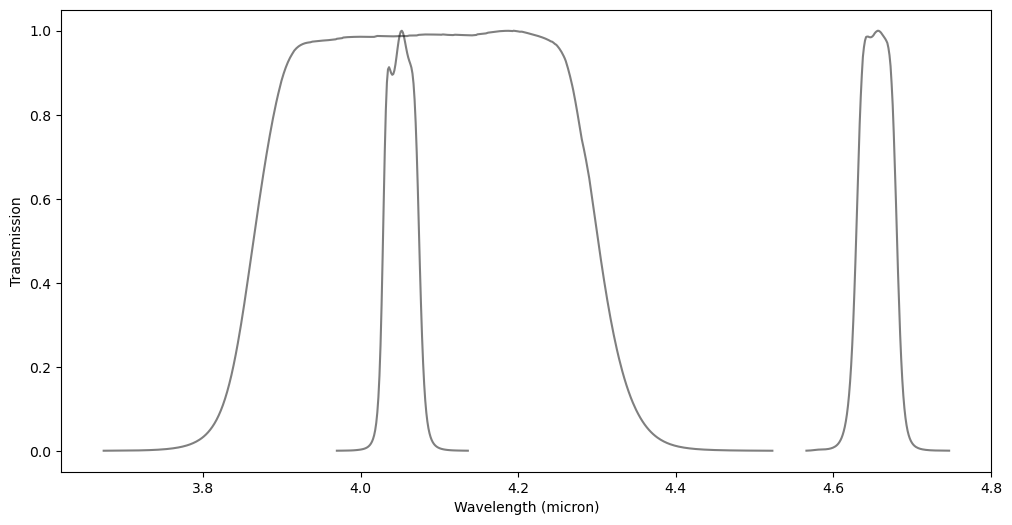

In [9]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_jwst.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [10]:
instrument = 'IRAC'
telescope = 'Spitzer'
wavelength_tables_spitzer = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                             for filt in ['I1', 'I2', 'I3', 'I4']}

wavelength_tables = {#'f470n': wavelength_table_470,
                     'f466n': wavelength_table_466,
                     'f410m': wavelength_table_410,
                     'f405n': wavelength_table_405,
                    }
wavelength_tables.update(wavelength_tables_spitzer)

Text(0, 0.5, 'Transmission')

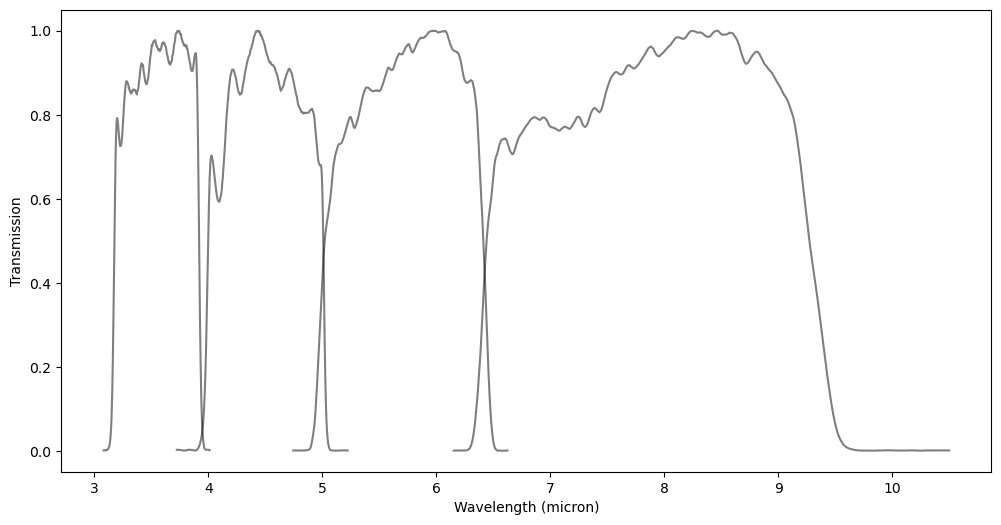

In [ ]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_spitzer.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [12]:
instrument = 'WISE'
telescope = 'WISE'
wavelength_tables_wise = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['W1', 'W2', 'W3', 'W4']}

Text(0, 0.5, 'Transmission')

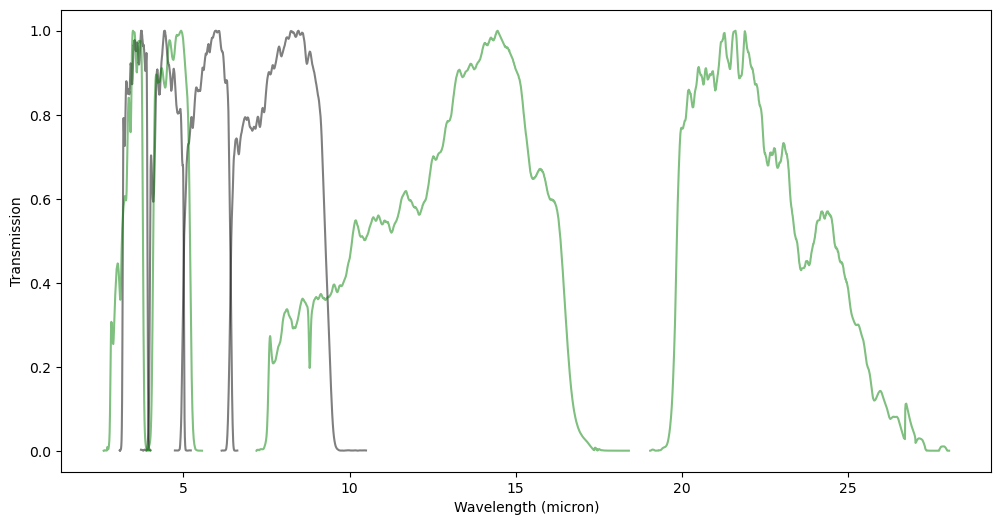

In [ ]:
fig = plt.figure(figsize=(12, 6))

#for filt, tbl in wavelength_tables_jwst.items():
#    xarr = tbl['Wavelength'].quantity.to(u.micron)
#    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

for filt, tbl in wavelength_tables_spitzer.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='g', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

Text(0, 0.5, 'Transmission')

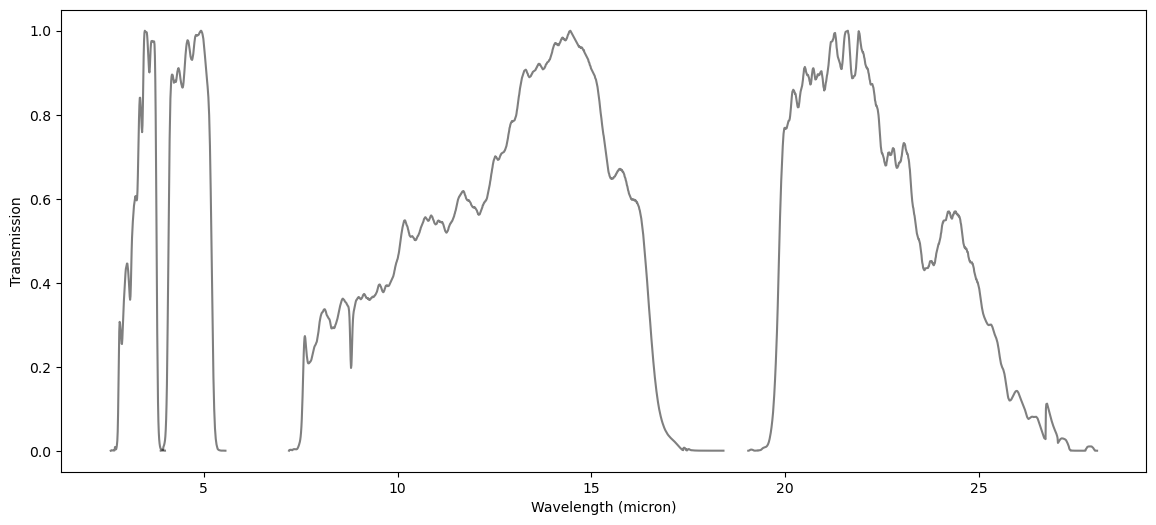

In [14]:
fig = plt.figure(figsize=(14, 6))

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [15]:
instrument = '2MASS'
telescope = '2MASS'
wavelength_tables_2mass = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['J', 'H', 'Ks']}

Text(0, 0.5, 'Transmission')

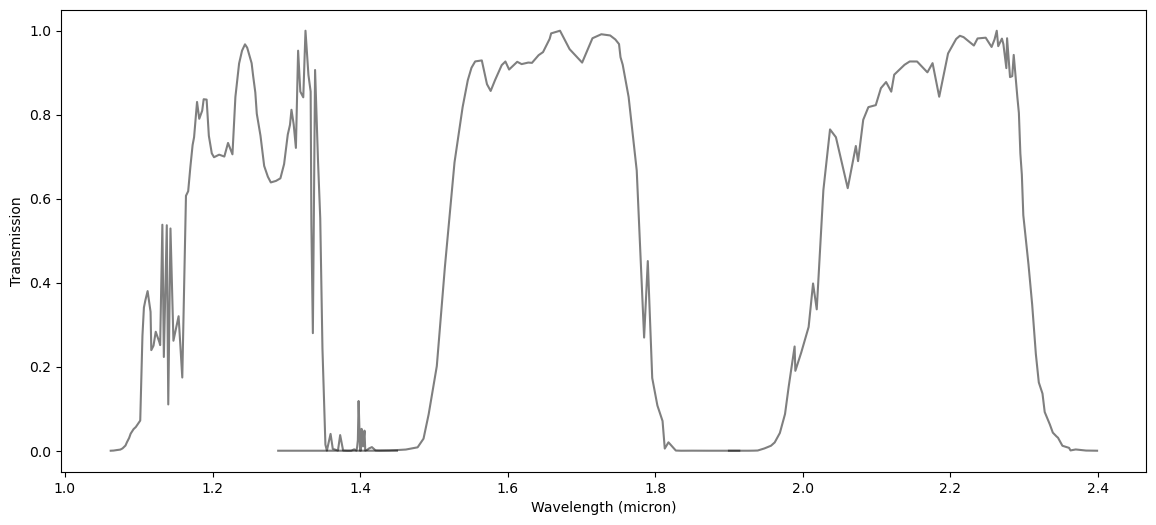

In [ ]:
fig = plt.figure(figsize=(14, 6))

for filt, tbl in wavelength_tables_2mass.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

# Ice Absorption

In [17]:
import icemodels.core
import importlib as imp
imp.reload(icemodels.core)
from icemodels.core import (phx4000, absorbed_spectrum, absorbed_spectrum_Gaussians, convsum,
                            fluxes_in_filters,
                            univap_molecule_data,
                            load_molecule, load_molecule_ocdb, load_molecule_univap, read_ocdb_file,
                            atmo_model, molecule_data)
from astropy import log
log.setLevel('DEBUG')
ice_model_table = load_molecule_ocdb('ch3oh.10k')
del molecule_data['h2o_b']
#del molecule_data['ch3oh']
del molecule_data['nh3']
del molecule_data['ch4']
log.setLevel('INFO')

DEBUG: molecule name = ch3oh.10k, ID=https://ocdb.smce.nasa.gov/dataset/78 [icemodels.core]


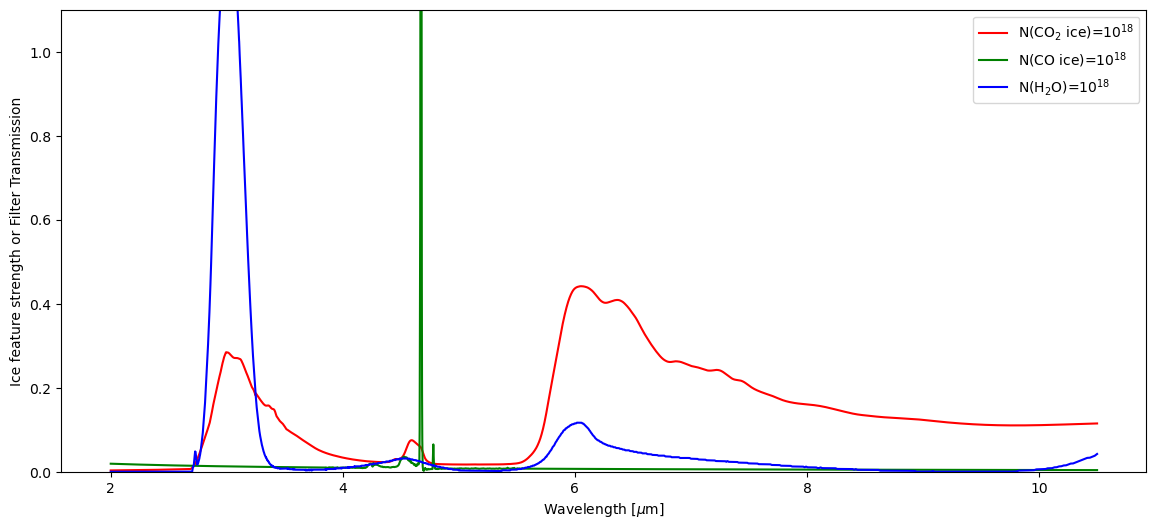

In [18]:
fig = plt.figure(figsize=(14, 6))
xarr = np.linspace(2.0, 10.5, int(5e4))*u.um

mol = load_molecule_ocdb('co2')
mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='r', label='N(CO$_2$ ice)=10$^{18}$')

#mol = load_molecule_ocdb('co')
optical_constants_cache_dir = '/red/adamginsburg/repos/icemodels/icemodels/data/'
baratta_co = read_ocdb_file(f'{optical_constants_cache_dir}/1_CO_(1)_12.5K_Baratta.txt')
#mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
mod = absorbed_spectrum(1e18*u.cm**-2, baratta_co, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='g', label='N(CO ice)=10$^{18}$')

#mol = load_molecule_ocdb('h2o:ch3oh:co:nh3.100:10:1:1.10k')
#mol = load_molecule_ocdb('h2o.10k')
h2o = read_ocdb_file(f'{optical_constants_cache_dir}/107_H2O (1)_10K_Hudgins.txt')
mod = absorbed_spectrum(1e18*u.cm**-2, h2o, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='b', label='N(H$_2$O)=10$^{18}$')

#mol = load_molecule_ocdb('ch3oh.10k')
#mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
#plt.plot(xarr, mod, color='m', label='N(CH$_3$OH)=10$^{18}$')

plt.ylim(0,1.1)
plt.xlabel(f"Wavelength [$\\mu$m]")
plt.ylabel("Ice feature strength or Filter Transmission")
plt.legend()
# 3.6 - 5.8, would water ice affect these at all? 
# proof of concept finesst proposal 
# molecular hydrogen! 

# Arrows

In [19]:
from astroquery.svo_fps import SvoFps
from astropy import table
filter_data_nircam = SvoFps.get_filter_list('JWST', instrument="NIRCam")
filter_data_miri = SvoFps.get_filter_list('JWST', instrument="MIRI")
filter_data_jwst = table.vstack([filter_data_nircam, filter_data_miri])
filter_data_spitzer_irac = SvoFps.get_filter_list('Spitzer', instrument='IRAC')
filter_data_spitzer_mips = SvoFps.get_filter_list('Spitzer', instrument='MIPS')
filter_data_spitzer = table.vstack([filter_data_spitzer_mips, filter_data_spitzer_irac])
filter_data_2mass = SvoFps.get_filter_list('2MASS')


for filter_data in (filter_data_jwst, filter_data_spitzer):
    filter_data.add_index('filterID')
    flxd = filter_data['filterID'] # TODO: might need to change this to only select the filters we're using below
    filter_wavelengths = [filter_data.loc[filterid]['WavelengthCen'] for filterid in flxd]
    filter_widths = [filter_data.loc[filterid]['WidthEff'] for filterid in flxd]
    filter_wlmin = [filter_data.loc[filterid]['WavelengthMin'] for filterid in flxd]
    filter_wlmax = [filter_data.loc[filterid]['WavelengthMax'] for filterid in flxd]

filter_data = filter_data_spitzer_irac#filter_data_jwst

In [20]:
distance = 8.5*u.kpc
av = 30
phx4000 = atmo_model(4000)
label_map = {'ch3oh': 'CH$_3$OH',
             'co2': 'CO$_2$',
             #'ch4': 'CH$_4$',
             'co': 'CO',
             'h2o': 'H$_2$O',
             #'nh3': 'NH$_3$',
            }

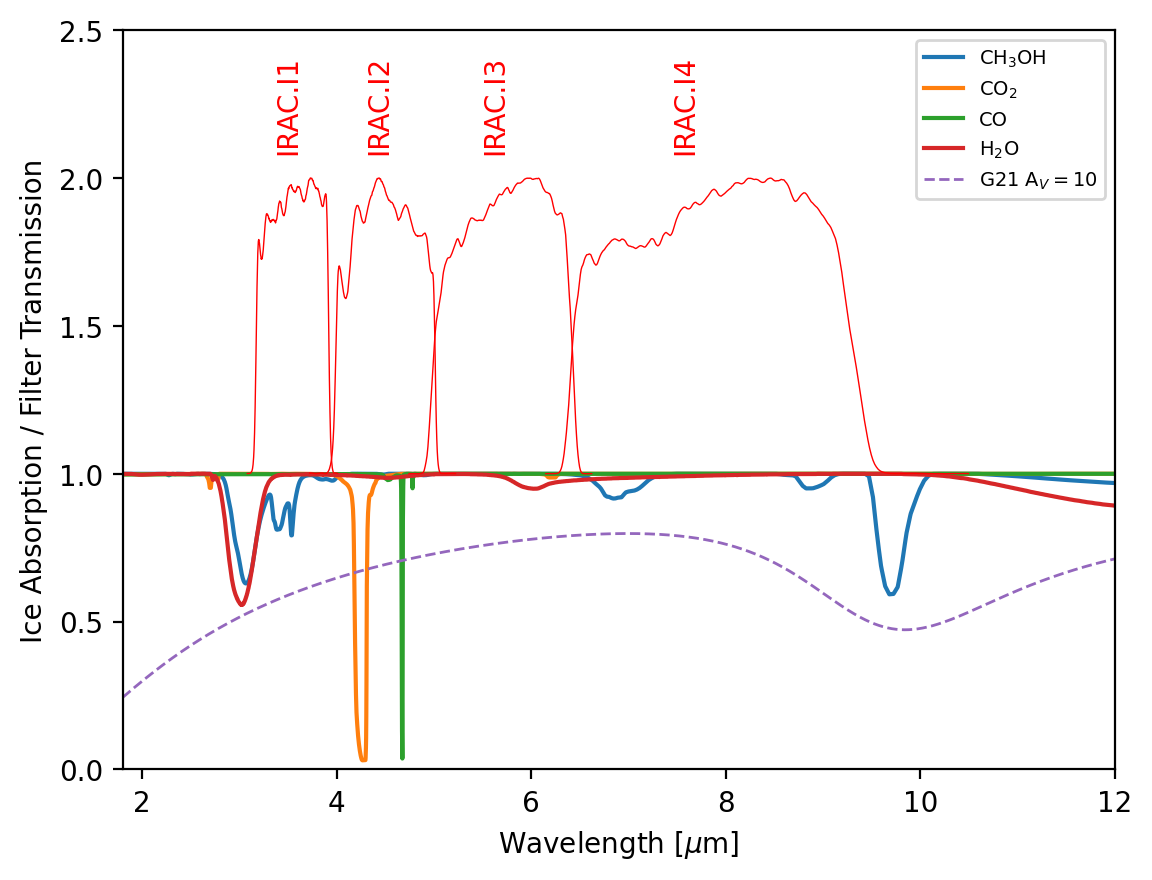

In [21]:
pl.figure(dpi=200)
# pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
#           phx4000['fnu'], color='k', linestyle=':', zorder=20,
#           linewidth=0.5)#, label="Phoenix T=4000 K")

xarr = u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral())
for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.plot(xarr,
              spec / phx4000['fnu'],
              label=f"{label_map[molecule]}")
    
for ext, extname in zip((G21_MWAvg(),),
                        ('G21', ),
                       ):
#for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
#                        ('F11', 'CT06', 'G21'),
#                       ):
    slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
           (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
    ext_ = ext.extinguish(xarr[slc], Av=10)
    pl.plot(xarr[slc], ext_, label=f'{extname} A$_V=10$', linestyle='--', linewidth=1)
    #pl.title("Opacity-based models")

toplot = ['IRAC.I1', 'IRAC.I2', 'IRAC.I3', 'IRAC.I4',]# 'MIPS.24mu']
for row in filter_data_spitzer:
    fname = row['filterID']
    if fname.split("/")[-1] in toplot:
        color = 'r'
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                2.1, fname.split("/")[-1], rotation=90, 
                horizontalalignment='center',
                color=color
               )
        trans = SvoFps.get_transmission_data(row['filterID'])
        pl.plot(trans['Wavelength'].quantity.to(u.um),
                trans['Transmission'].value/trans['Transmission'].value.max() + 1,
                linewidth=0.5, color=color)
        #if row['filterID'].endswith('M') and row['WavelengthEff'] > 25000:
        #    pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
        #            0.1, row['filterID'][-5:], rotation=90,
        #            color='orange')

pl.legend(loc='upper right', fontsize=7)#bbox_to_anchor=[1.0, 1.0])
pl.ylim(0, 2.5)
pl.xlim(1.8, 12)
pl.ylabel("Ice Absorption / Filter Transmission")
pl.xlabel("Wavelength [$\\mu$m]");
#pl.savefig("Spitzer_IceWindows.png", bbox_inches='tight');
#pl.savefig("Spitzer_IceWindows.pdf", bbox_inches='tight');

In [22]:
temperatures = (2000, 3000, 4000, 5000, 7000, 10000, 12000, 15000, 25000, 39000)

tmods = {temperature: atmo_model(temperature)
         for temperature in temperatures}

<Quantity 2.60099253e-15 erg / (Hz s cm2)>

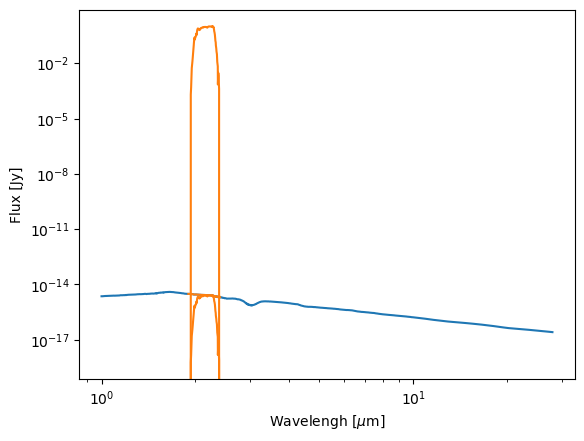

In [23]:
def fluxes_in_one_filter(fid, xarr, modeldata, doplot=False):
    # fid example: Spitzer/IRAC.I1

    if doplot:
        pl.loglog(xarr.to(u.um), modeldata)
        pl.xlabel("Wavelengh [$\\mu$m]")
        pl.ylabel("Flux [Jy]")
    
    fluxes = convsum(xarr, modeldata, SvoFps.get_transmission_data(fid), doplot=doplot)
    return fluxes


fluxes_in_one_filter('2MASS/2MASS.Ks', xarr, spec, doplot=True)

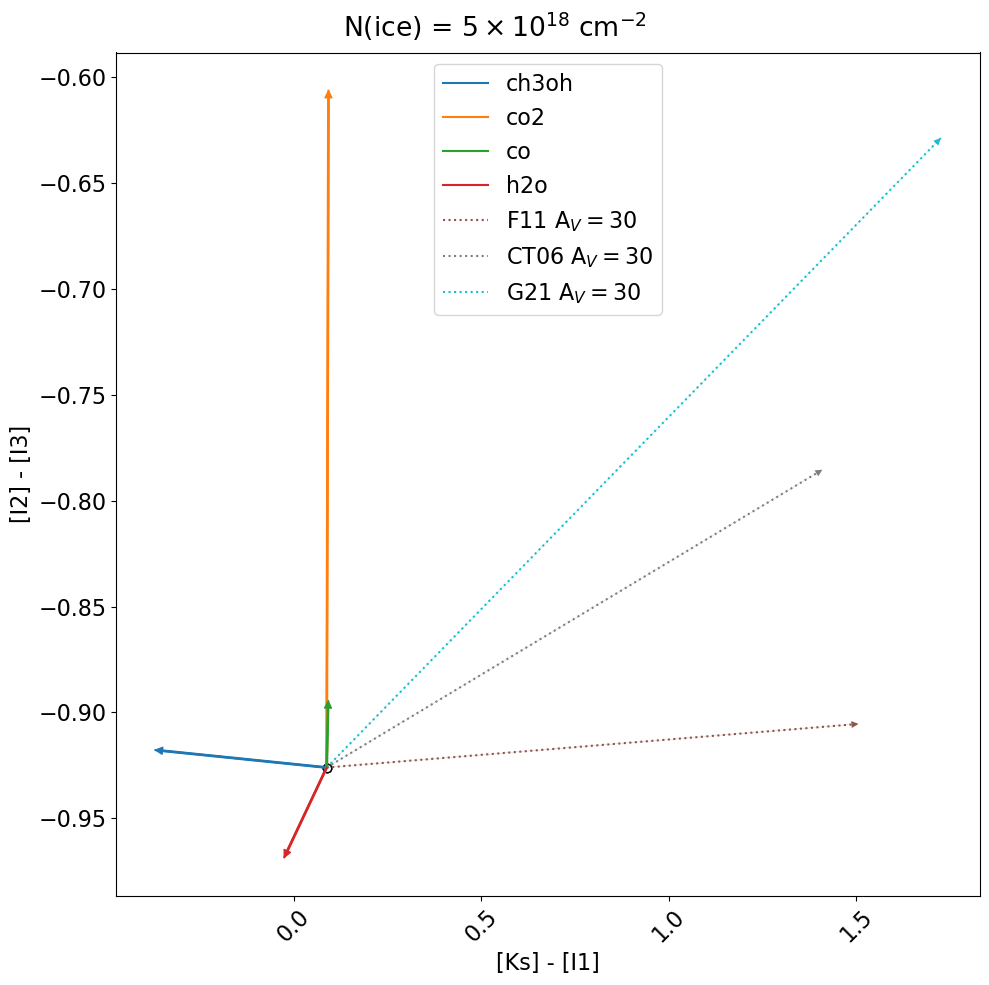

In [24]:
import matplotlib
ccds2 = [
    (('2MASS/2MASS.Ks', 'Spitzer/IRAC.I1'),
     ('Spitzer/IRAC.I2', 'Spitzer/IRAC.I3')),
#    (('JWST/NIRCam.F212N', 'JWST/NIRCam.F410M'),
#     ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')),
# no ice    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F182M'),
# no ice     ('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N')),

]    

temperature = 4000

pl.figure(figsize=(10, 10), dpi=100)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())


with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(ccds2):
        ax = pl.subplot(1, 1, ii+1)
        ax.set_xlabel(f'[{cmd_x[0].split(".")[-1]}] - [{cmd_x[1].split(".")[-1]}]')
        ax.set_ylabel(f'[{cmd_y[0].split(".")[-1]}] - [{cmd_y[1].split(".")[-1]}]')

        
        xarr_ref = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
        flxd_ref = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
        xs,ys,us,vs,cs = [],[],[],[],[]
        for (molecule, moldata), color in zip(molecule_data.items(),
                                            pl.rcParams['axes.prop_cycle'].by_key()['color']):
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=molecule_data[molecule]['molwt'],
                                      spectrum=tmods[temperature]['fnu'].quantity,
                                      xarr=xarr,
                                     )

            flxd = fluxes_in_filters(xarr, spec)
            mags_x_star = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y_star = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x_star[0]-mags_x_star[1])
            ydata.append(mags_y_star[0]-mags_y_star[1])
            mags_x = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr,spec) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=molecule)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=1, headwidth=5, headlength=5,
                        edgecolor=L.get_color(),
                        facecolor=L.get_color(),
                                       ),
                        color=L.get_color(),
                       )
            #L.set_visible(False) # hide these, but force the ax lims?
            #dx = pl.xlim()[1] - pl.xlim()[0]
            #ax.arrow(xdata[0], ydata[0], xdata[1]-xdata[0], ydata[1]-ydata[0])#, width=dx/30)
            xs.append(xdata[0])
            ys.append(ydata[0])
            us.append(xdata[1]-xdata[0])
            vs.append(ydata[1]-ydata[0])
            cs.append(color)
            #ax.set_xticklabels(rotation=45) # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
            ax.tick_params(axis='x', labelrotation=45)
            #print(xdata, ydata)
            #for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
            #    ax.scatter(xx, yy, marker=marker, color=L.get_color())
            #print(xx, yy)
        for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                                ('F11', 'CT06', 'G21'),
                               ):
            slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
                   (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
            attenuation = 10**(-ext(xarr[slc]) * av / 2.5)
            extspec = spec[slc] * attenuation
            flxd_ext = fluxes_in_filters(xarr[slc], extspec)
            xdata = [mags_x_star[0]-mags_x_star[1]]
            ydata = [mags_y_star[0]-mags_y_star[1]]
            ax.plot(xdata, ydata, marker='o', markerfacecolor='w', markeredgecolor='k', zorder=-10)
            mags_x = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            L, = ax.plot(xdata, ydata, label=f'{extname} A$_V={av}$', linestyle=':')
            #L.set_visible(False)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=0.1, headwidth=5, headlength=5,
                                        edgecolor='none', #L.get_color(),
                                        facecolor=L.get_color(),
                                        linestyle=':',
                                       ),
                        color=L.get_color(),
                        #label=f'{extname} A$_V={av}$',
                       )
        # can't label with quiver.
        # ax.quiver(xs, ys, us, vs, np.arange(len(xs)), angles='xy', cmap='rainbow',
        #           scale_units='xy',
        #           scale=1,
        #          )
        # https://stackoverflow.com/questions/45148539/project-variables-in-pca-plot-in-python
        #dx = pl.xlim()[1] - pl.xlim()[0]
        #for arrow in ax.patches:
        #    arrow.set_data(width=dx/50)
        

    pl.legend(loc='best')#upper right', bbox_to_anchor=[1.00,1.05])
    pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()

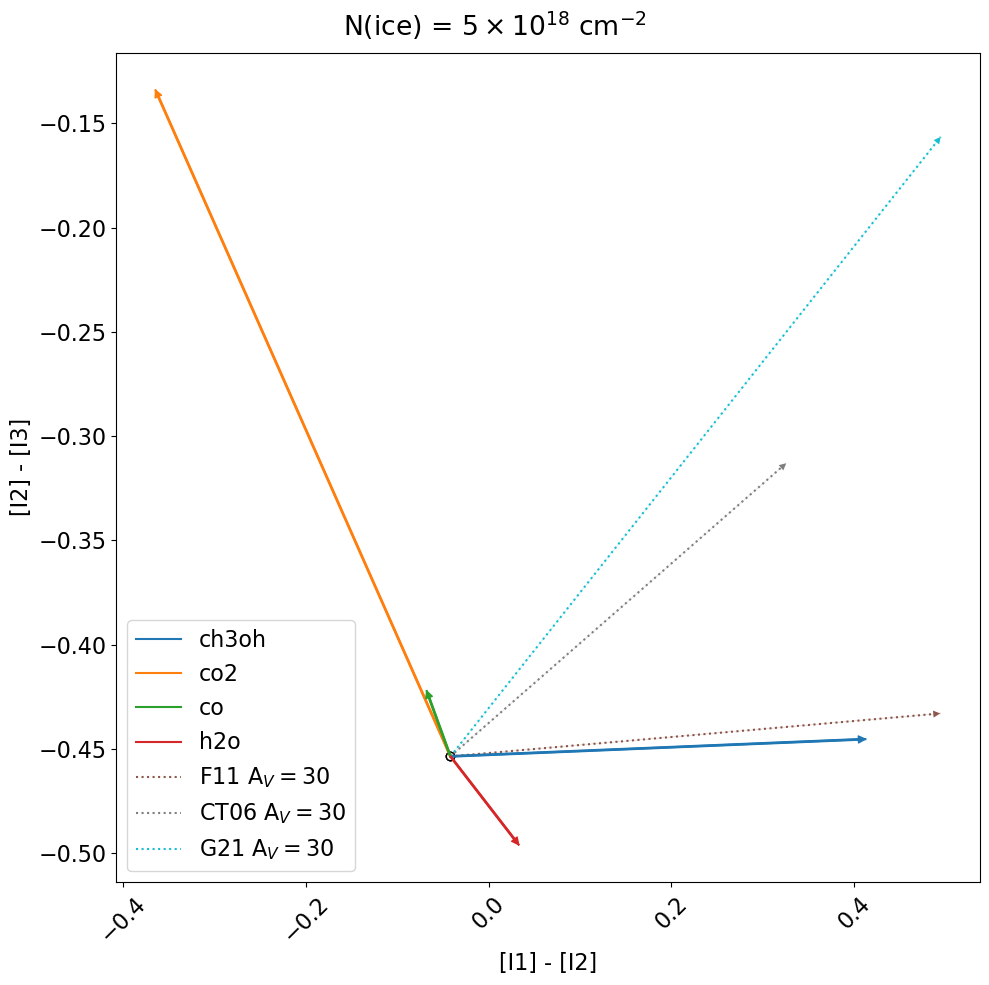

In [25]:
import matplotlib
ccds2 = [
    (('Spitzer/IRAC.I1', 'Spitzer/IRAC.I2'),
     ('Spitzer/IRAC.I2', 'Spitzer/IRAC.I3')),
#    (('JWST/NIRCam.F212N', 'JWST/NIRCam.F410M'),
#     ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')),
# no ice    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F182M'),
# no ice     ('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N')),

]    

temperature = 4000

pl.figure(figsize=(10, 10), dpi=100)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())


with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(ccds2):
        ax = pl.subplot(1, 1, ii+1)
        ax.set_xlabel(f'[{cmd_x[0].split(".")[-1]}] - [{cmd_x[1].split(".")[-1]}]')
        ax.set_ylabel(f'[{cmd_y[0].split(".")[-1]}] - [{cmd_y[1].split(".")[-1]}]')

        
        xarr_ref = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
        flxd_ref = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
        xs,ys,us,vs,cs = [],[],[],[],[]
        for (molecule, moldata), color in zip(molecule_data.items(),
                                            pl.rcParams['axes.prop_cycle'].by_key()['color']):
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=molecule_data[molecule]['molwt'],
                                      spectrum=tmods[temperature]['fnu'].quantity,
                                      xarr=xarr,
                                     )

            flxd = fluxes_in_filters(xarr, spec)
            mags_x_star = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y_star = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x_star[0]-mags_x_star[1])
            ydata.append(mags_y_star[0]-mags_y_star[1])
            mags_x = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr,spec) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=molecule)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=1, headwidth=5, headlength=5,
                        edgecolor=L.get_color(),
                        facecolor=L.get_color(),
                                       ),
                        color=L.get_color(),
                       )
            #L.set_visible(False) # hide these, but force the ax lims?
            #dx = pl.xlim()[1] - pl.xlim()[0]
            #ax.arrow(xdata[0], ydata[0], xdata[1]-xdata[0], ydata[1]-ydata[0])#, width=dx/30)
            xs.append(xdata[0])
            ys.append(ydata[0])
            us.append(xdata[1]-xdata[0])
            vs.append(ydata[1]-ydata[0])
            cs.append(color)
            #ax.set_xticklabels(rotation=45) # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
            ax.tick_params(axis='x', labelrotation=45)
            #print(xdata, ydata)
            #for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
            #    ax.scatter(xx, yy, marker=marker, color=L.get_color())
            #print(xx, yy)
        for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                                ('F11', 'CT06', 'G21'),
                               ):
            slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
                   (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
            attenuation = 10**(-ext(xarr[slc]) * av / 2.5)
            extspec = spec[slc] * attenuation
            flxd_ext = fluxes_in_filters(xarr[slc], extspec)
            xdata = [mags_x_star[0]-mags_x_star[1]]
            ydata = [mags_y_star[0]-mags_y_star[1]]
            ax.plot(xdata, ydata, marker='o', markerfacecolor='w', markeredgecolor='k', zorder=-10)
            mags_x = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            L, = ax.plot(xdata, ydata, label=f'{extname} A$_V={av}$', linestyle=':')
            #L.set_visible(False)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=0.1, headwidth=5, headlength=5,
                                        edgecolor='none', #L.get_color(),
                                        facecolor=L.get_color(),
                                        linestyle=':',
                                       ),
                        color=L.get_color(),
                        #label=f'{extname} A$_V={av}$',
                       )
        # can't label with quiver.
        # ax.quiver(xs, ys, us, vs, np.arange(len(xs)), angles='xy', cmap='rainbow',
        #           scale_units='xy',
        #           scale=1,
        #          )
        # https://stackoverflow.com/questions/45148539/project-variables-in-pca-plot-in-python
        #dx = pl.xlim()[1] - pl.xlim()[0]
        #for arrow in ax.patches:
        #    arrow.set_data(width=dx/50)
        

    pl.legend(loc='best')#upper right', bbox_to_anchor=[1.00,1.05])
    pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()

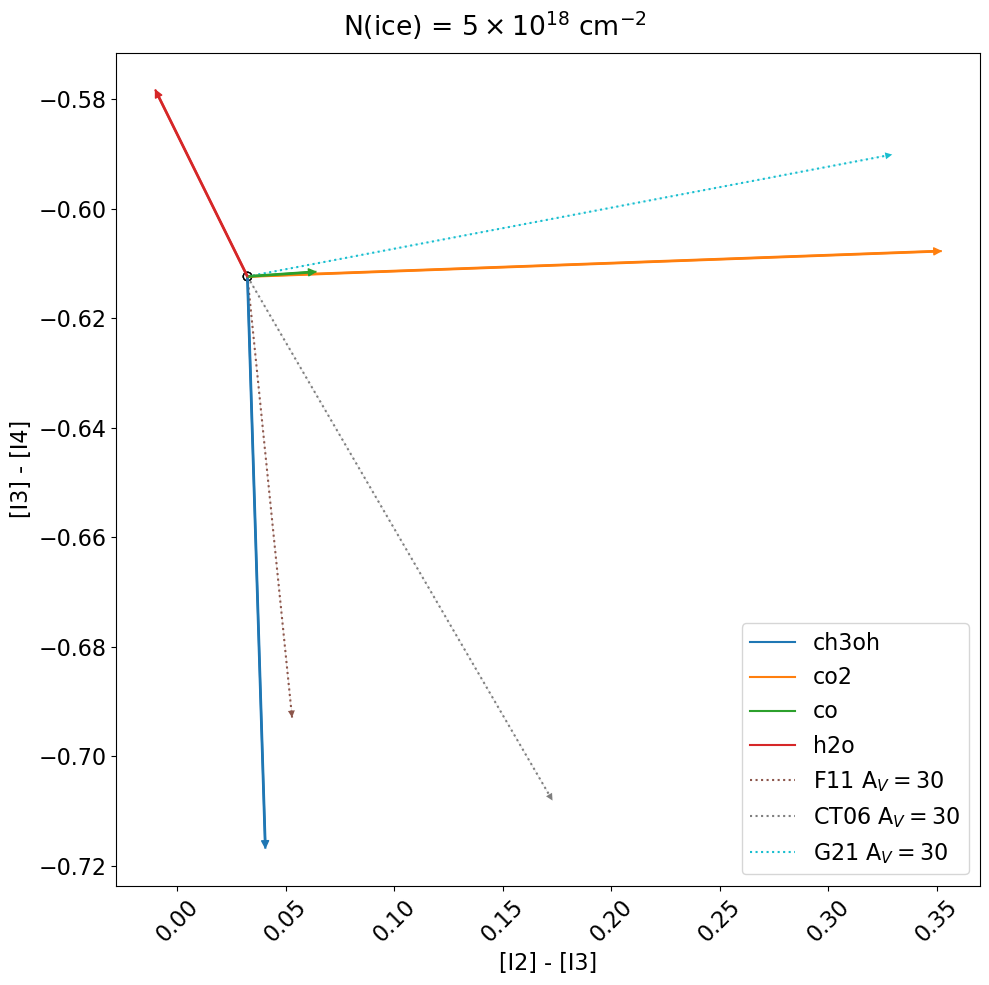

In [27]:
import matplotlib
ccds2 = [
    (('Spitzer/IRAC.I2', 'Spitzer/IRAC.I3'),
     ('Spitzer/IRAC.I3', 'Spitzer/IRAC.I4')),
#    (('JWST/NIRCam.F212N', 'JWST/NIRCam.F410M'),
#     ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')),
# no ice    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F182M'),
# no ice     ('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N')),

]    

temperature = 4000

pl.figure(figsize=(10, 10), dpi=100)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())


with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(ccds2):
        ax = pl.subplot(1, 1, ii+1)
        ax.set_xlabel(f'[{cmd_x[0].split(".")[-1]}] - [{cmd_x[1].split(".")[-1]}]')
        ax.set_ylabel(f'[{cmd_y[0].split(".")[-1]}] - [{cmd_y[1].split(".")[-1]}]')

        
        xarr_ref = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
        flxd_ref = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
        xs,ys,us,vs,cs = [],[],[],[],[]
        for (molecule, moldata), color in zip(molecule_data.items(),
                                            pl.rcParams['axes.prop_cycle'].by_key()['color']):
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=molecule_data[molecule]['molwt'],
                                      spectrum=tmods[temperature]['fnu'].quantity,
                                      xarr=xarr,
                                     )

            flxd = fluxes_in_filters(xarr, spec)
            mags_x_star = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y_star = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x_star[0]-mags_x_star[1])
            ydata.append(mags_y_star[0]-mags_y_star[1])
            mags_x = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr,spec) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=molecule)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=1, headwidth=5, headlength=5,
                        edgecolor=L.get_color(),
                        facecolor=L.get_color(),
                                       ),
                        color=L.get_color(),
                       )
            #L.set_visible(False) # hide these, but force the ax lims?
            #dx = pl.xlim()[1] - pl.xlim()[0]
            #ax.arrow(xdata[0], ydata[0], xdata[1]-xdata[0], ydata[1]-ydata[0])#, width=dx/30)
            xs.append(xdata[0])
            ys.append(ydata[0])
            us.append(xdata[1]-xdata[0])
            vs.append(ydata[1]-ydata[0])
            cs.append(color)
            #ax.set_xticklabels(rotation=45) # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
            ax.tick_params(axis='x', labelrotation=45)
            #print(xdata, ydata)
            #for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
            #    ax.scatter(xx, yy, marker=marker, color=L.get_color())
            #print(xx, yy)
        for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                                ('F11', 'CT06', 'G21'),
                               ):
            slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
                   (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
            attenuation = 10**(-ext(xarr[slc]) * av / 2.5)
            extspec = spec[slc] * attenuation
            flxd_ext = fluxes_in_filters(xarr[slc], extspec)
            xdata = [mags_x_star[0]-mags_x_star[1]]
            ydata = [mags_y_star[0]-mags_y_star[1]]
            ax.plot(xdata, ydata, marker='o', markerfacecolor='w', markeredgecolor='k', zorder=-10)
            mags_x = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            L, = ax.plot(xdata, ydata, label=f'{extname} A$_V={av}$', linestyle=':')
            #L.set_visible(False)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=0.1, headwidth=5, headlength=5,
                                        edgecolor='none', #L.get_color(),
                                        facecolor=L.get_color(),
                                        linestyle=':',
                                       ),
                        color=L.get_color(),
                        #label=f'{extname} A$_V={av}$',
                       )
        # can't label with quiver.
        # ax.quiver(xs, ys, us, vs, np.arange(len(xs)), angles='xy', cmap='rainbow',
        #           scale_units='xy',
        #           scale=1,
        #          )
        # https://stackoverflow.com/questions/45148539/project-variables-in-pca-plot-in-python
        #dx = pl.xlim()[1] - pl.xlim()[0]
        #for arrow in ax.patches:
        #    arrow.set_data(width=dx/50)
        

    pl.legend(loc='best')#upper right', bbox_to_anchor=[1.00,1.05])
    pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()

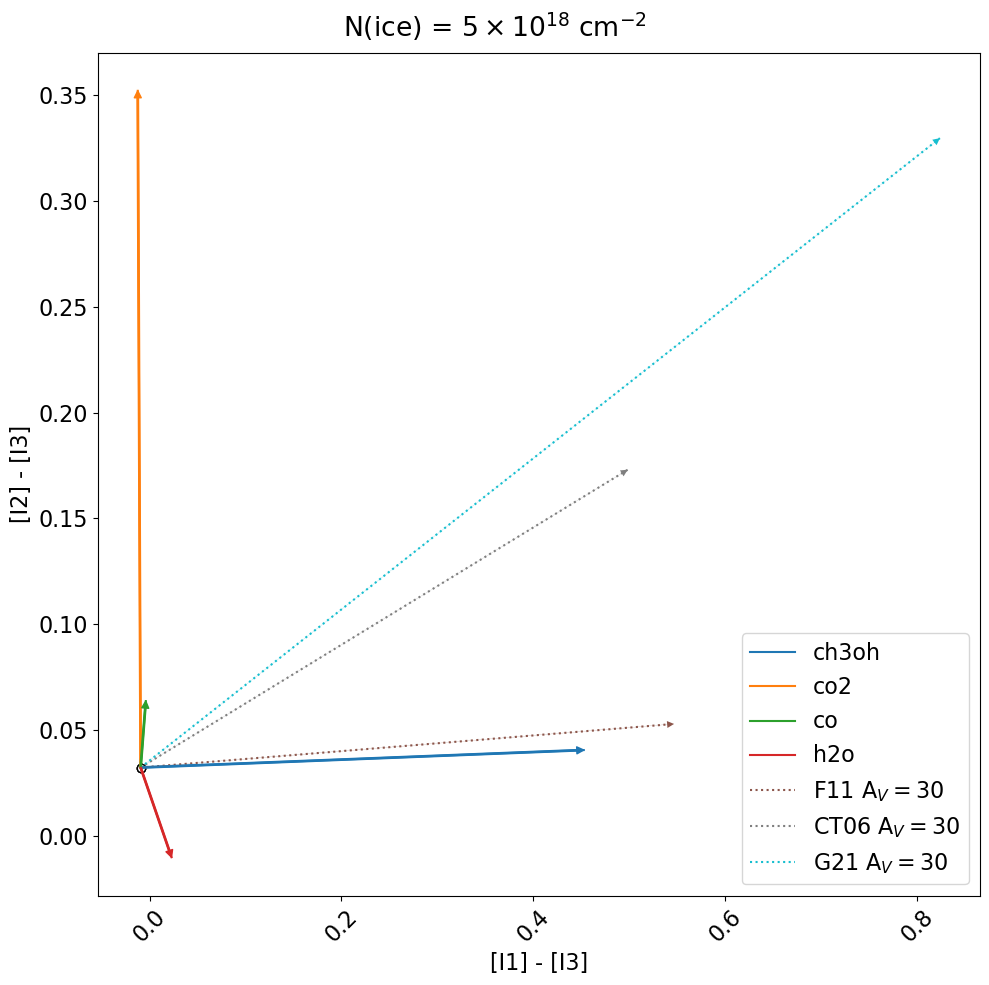

In [28]:
import matplotlib
ccds2 = [
    (('Spitzer/IRAC.I1', 'Spitzer/IRAC.I3'),
     ('Spitzer/IRAC.I2', 'Spitzer/IRAC.I3')),
#    (('JWST/NIRCam.F212N', 'JWST/NIRCam.F410M'),
#     ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')),
# no ice    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F182M'),
# no ice     ('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N')),

]    

temperature = 4000

pl.figure(figsize=(10, 10), dpi=100)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())


with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(ccds2):
        ax = pl.subplot(1, 1, ii+1)
        ax.set_xlabel(f'[{cmd_x[0].split(".")[-1]}] - [{cmd_x[1].split(".")[-1]}]')
        ax.set_ylabel(f'[{cmd_y[0].split(".")[-1]}] - [{cmd_y[1].split(".")[-1]}]')

        
        xarr_ref = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
        flxd_ref = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
        xs,ys,us,vs,cs = [],[],[],[],[]
        for (molecule, moldata), color in zip(molecule_data.items(),
                                            pl.rcParams['axes.prop_cycle'].by_key()['color']):
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=molecule_data[molecule]['molwt'],
                                      spectrum=tmods[temperature]['fnu'].quantity,
                                      xarr=xarr,
                                     )

            flxd = fluxes_in_filters(xarr, spec)
            mags_x_star = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y_star = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr,tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x_star[0]-mags_x_star[1])
            ydata.append(mags_y_star[0]-mags_y_star[1])
            mags_x = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr,spec) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=molecule)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=1, headwidth=5, headlength=5,
                        edgecolor=L.get_color(),
                        facecolor=L.get_color(),
                                       ),
                        color=L.get_color(),
                       )
            #L.set_visible(False) # hide these, but force the ax lims?
            #dx = pl.xlim()[1] - pl.xlim()[0]
            #ax.arrow(xdata[0], ydata[0], xdata[1]-xdata[0], ydata[1]-ydata[0])#, width=dx/30)
            xs.append(xdata[0])
            ys.append(ydata[0])
            us.append(xdata[1]-xdata[0])
            vs.append(ydata[1]-ydata[0])
            cs.append(color)
            #ax.set_xticklabels(rotation=45) # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
            ax.tick_params(axis='x', labelrotation=45)
            #print(xdata, ydata)
            #for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
            #    ax.scatter(xx, yy, marker=marker, color=L.get_color())
            #print(xx, yy)
        for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                                ('F11', 'CT06', 'G21'),
                               ):
            slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
                   (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
            attenuation = 10**(-ext(xarr[slc]) * av / 2.5)
            extspec = spec[slc] * attenuation
            flxd_ext = fluxes_in_filters(xarr[slc], extspec)
            xdata = [mags_x_star[0]-mags_x_star[1]]
            ydata = [mags_y_star[0]-mags_y_star[1]]
            ax.plot(xdata, ydata, marker='o', markerfacecolor='w', markeredgecolor='k', zorder=-10)
            mags_x = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            L, = ax.plot(xdata, ydata, label=f'{extname} A$_V={av}$', linestyle=':')
            #L.set_visible(False)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=0.1, headwidth=5, headlength=5,
                                        edgecolor='none', #L.get_color(),
                                        facecolor=L.get_color(),
                                        linestyle=':',
                                       ),
                        color=L.get_color(),
                        #label=f'{extname} A$_V={av}$',
                       )
        # can't label with quiver.
        # ax.quiver(xs, ys, us, vs, np.arange(len(xs)), angles='xy', cmap='rainbow',
        #           scale_units='xy',
        #           scale=1,
        #          )
        # https://stackoverflow.com/questions/45148539/project-variables-in-pca-plot-in-python
        #dx = pl.xlim()[1] - pl.xlim()[0]
        #for arrow in ax.patches:
        #    arrow.set_data(width=dx/50)
        

    pl.legend(loc='best')#upper right', bbox_to_anchor=[1.00,1.05])
    pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()

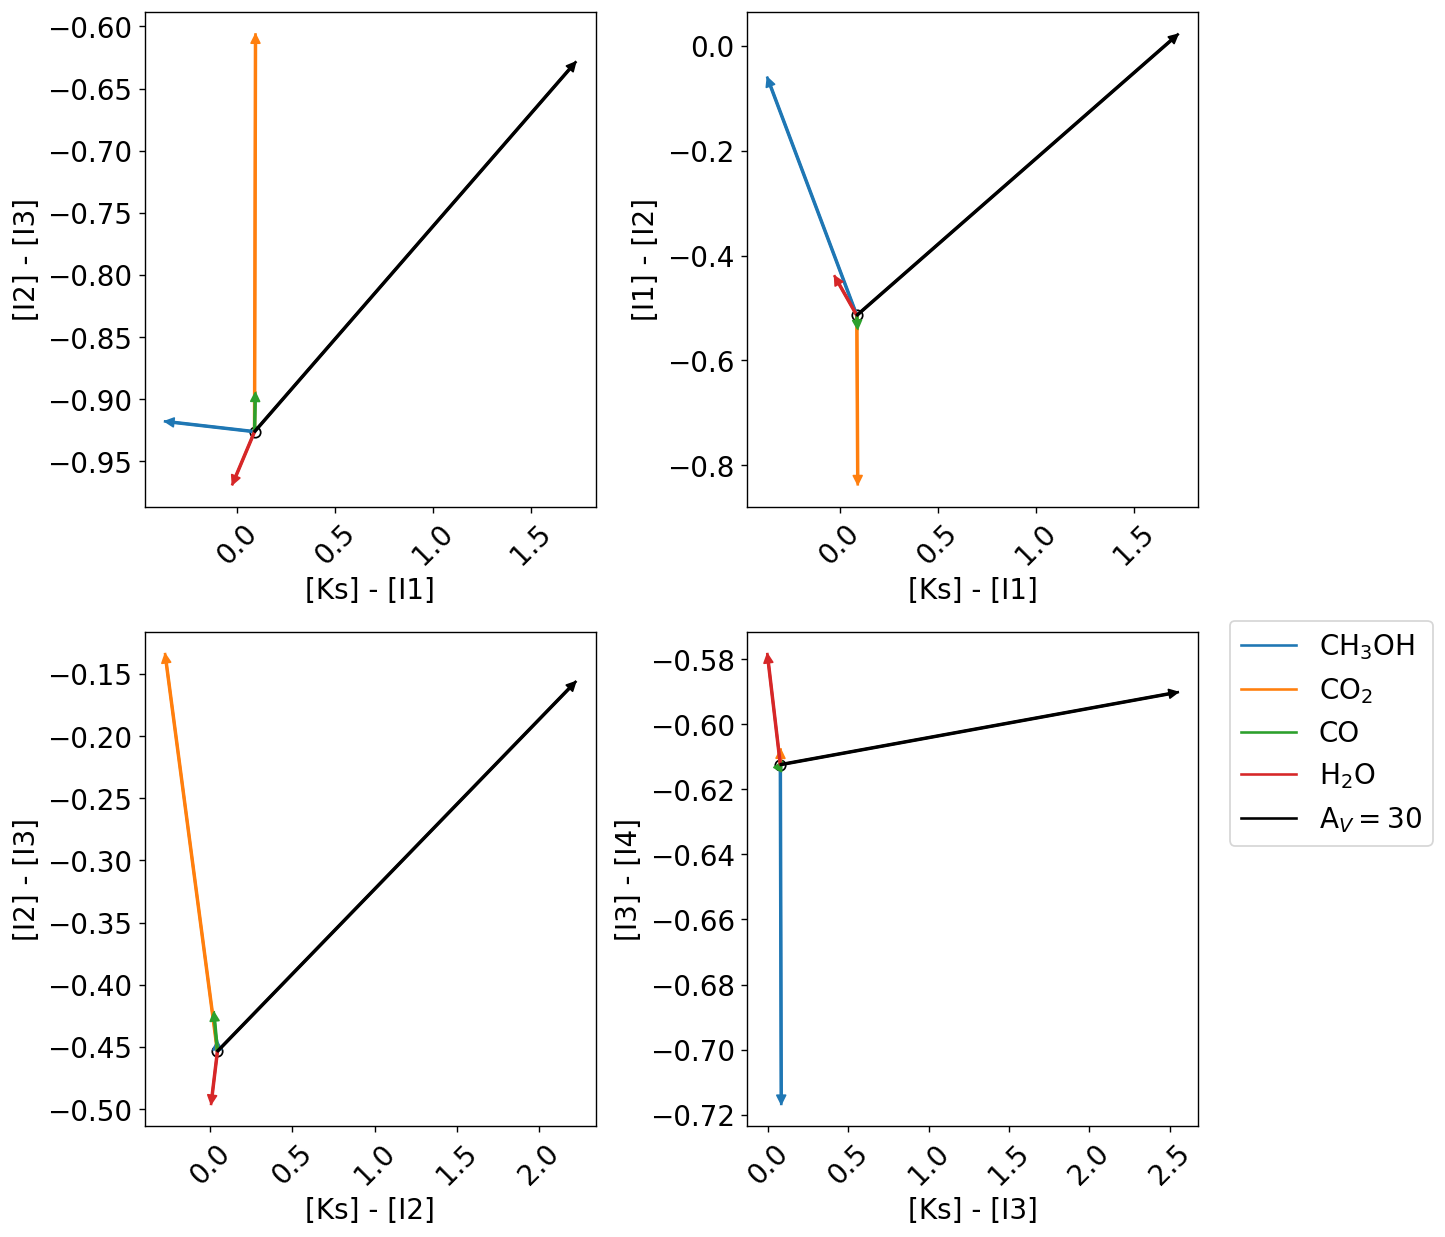

In [26]:
pl.figure(figsize=(12, 10), dpi=125)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())

temperature = 4000
cmds = [# too boring (('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N'),
        # too boring  ('JWST/NIRCam.F115W', 'JWST/NIRCam.F200W')),
        (('2MASS/2MASS.Ks', 'Spitzer/IRAC.I1'),
         ('Spitzer/IRAC.I2', 'Spitzer/IRAC.I3')),
        (('2MASS/2MASS.Ks', 'Spitzer/IRAC.I1'),
         ('Spitzer/IRAC.I1', 'Spitzer/IRAC.I2')),
        (('2MASS/2MASS.Ks', 'Spitzer/IRAC.I2'),
         ('Spitzer/IRAC.I2', 'Spitzer/IRAC.I3')),
        (('2MASS/2MASS.Ks', 'Spitzer/IRAC.I3'),
         ('Spitzer/IRAC.I3', 'Spitzer/IRAC.I4')),
        #(('JWST/NIRCam.F356W', 'JWST/NIRCam.F444W'),
        # ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')),
        # #('JWST/NIRCam.F115W', 'JWST/NIRCam.F200W')),
        #(('JWST/NIRCam.F150W', 'JWST/NIRCam.F210M'),
        # ('JWST/NIRCam.F300M', 'JWST/NIRCam.F335M')),
        ##(('JWST/NIRCam.F300M', 'JWST/NIRCam.F356W'),
        ## ('JWST/NIRCam.F466N', 'JWST/NIRCam.F444W')),
        #(('JWST/MIRI.F560W', 'JWST/MIRI.F770W'),
        # ('JWST/MIRI.F1000W', 'JWST/MIRI.F1130W')),
        #(('JWST/MIRI.F1280W', 'JWST/MIRI.F1500W'),
        # ('JWST/MIRI.F1800W', 'JWST/MIRI.F2100W')),
       ]

ext =  CT06_MWGC()

with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(cmds):
        ax = pl.subplot(2, 2, ii+1)
        ax.set_xlabel(f'[{cmd_x[0].split(".")[-1]}] - [{cmd_x[1].split(".")[-1]}]')
        ax.set_ylabel(f'[{cmd_y[0].split(".")[-1]}] - [{cmd_y[1].split(".")[-1]}]')

        
        xarr_ref = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
        flxd_ref = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
        xs,ys,us,vs,cs = [],[],[],[],[]
        for (molecule, moldata), color in zip(molecule_data.items(),
                                            pl.rcParams['axes.prop_cycle'].by_key()['color']):
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=molecule_data[molecule]['molwt'],
                                      spectrum=tmods[temperature]['fnu'].quantity,
                                      xarr=xarr,
                                     )

            flxd = fluxes_in_filters(xarr, spec)
            mags_x_star = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0], xarr, tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(fluxes_in_one_filter(cmd_x[1], xarr, tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y_star = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0], xarr, tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(fluxes_in_one_filter(cmd_y[1], xarr, tmods[temperature]['fnu'].quantity) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x_star[0]-mags_x_star[1])
            ydata.append(mags_y_star[0]-mags_y_star[1])
            mags_x = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr,spec) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr,spec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=label_map[molecule])
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=1, headwidth=5, headlength=5,
                        edgecolor=L.get_color(),
                        facecolor=L.get_color(),
                                       ),
                        color=L.get_color(),
                       )
            #L.set_visible(False) # hide these, but force the ax lims?
            #dx = pl.xlim()[1] - pl.xlim()[0]
            #ax.arrow(xdata[0], ydata[0], xdata[1]-xdata[0], ydata[1]-ydata[0])#, width=dx/30)
            xs.append(xdata[0])
            ys.append(ydata[0])
            us.append(xdata[1]-xdata[0])
            vs.append(ydata[1]-ydata[0])
            cs.append(color)
            #ax.set_xticklabels(rotation=45) # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
            ax.tick_params(axis='x', labelrotation=45)
            #print(xdata, ydata)
            #for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
            #    ax.scatter(xx, yy, marker=marker, color=L.get_color())
            #print(xx, yy)
        slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
               (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
        attenuation = 10**(-ext(xarr[slc]) * av / 2.5)
        extspec = spec[slc] * attenuation
        flxd_ext = fluxes_in_filters(xarr[slc], extspec)
        xdata = [mags_x_star[0]-mags_x_star[1]]
        ydata = [mags_y_star[0]-mags_y_star[1]]
        ax.plot(xdata, ydata, marker='o', markerfacecolor='w', markeredgecolor='k', zorder=-10)
        mags_x = (-2.5*np.log10(fluxes_in_one_filter(cmd_x[0],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                  -2.5*np.log10(fluxes_in_one_filter(cmd_x[1],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
        mags_y = (-2.5*np.log10(fluxes_in_one_filter(cmd_y[0],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                  -2.5*np.log10(fluxes_in_one_filter(cmd_y[1],xarr[slc],extspec) / u.Quantity(combined_filters.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
        xdata.append(mags_x[0]-mags_x[1])
        ydata.append(mags_y[0]-mags_y[1])
        L, = ax.plot(xdata, ydata, label=f'A$_V={av}$', color='k')
        arrow_start = xdata[0], ydata[0]
        arrow_end = xdata[1], ydata[1]
        ax.annotate('', arrow_end, arrow_start,
                    arrowprops=dict(width=1, headwidth=5, headlength=5,
                    edgecolor=L.get_color(),
                    facecolor=L.get_color(),
                                   ),
                    color=L.get_color(),
                   )
        # can't label with quiver.
        # ax.quiver(xs, ys, us, vs, np.arange(len(xs)), angles='xy', cmap='rainbow',
        #           scale_units='xy',
        #           scale=1,
        #          )
        # https://stackoverflow.com/questions/45148539/project-variables-in-pca-plot-in-python
        #dx = pl.xlim()[1] - pl.xlim()[0]
        #for arrow in ax.patches:
        #    arrow.set_data(width=dx/50)
        
        #if ii == 0:
        #    ax.text(0.07, 0.94, "Archival Filters", transform=ax.transAxes)
        #else:
        #    ax.text(0.05, 0.94, "Proposed Filters", transform=ax.transAxes)


    pl.legend(loc='upper right', bbox_to_anchor=[1.55,1.05])
    #pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()

In [27]:
combined_filters.loc['2MASS/2MASS.Ks']

FilterProfileService,filterID,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,Description,Comments,WavelengthRef,WavelengthMean,WavelengthEff,WavelengthMin,WavelengthMax,WidthEff,WavelengthCen,WavelengthPivot,WavelengthPeak,WavelengthPhot,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
,,,,,,,,,,,,,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,erg / (A s cm2),,,Jy,,,,,
object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,object,float64,object,float64,object
ivo://svo/fps,2MASS/2MASS.Ks,Angstrom,em.wl,2MASS,0,Ks,,2MASS,http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html#rsr,http://adsabs.harvard.edu/abs/2003AJ....126.1090C,2MASS Ks,,21590.0,21590.0,21590.0,19543.692304348,23552.400005256,2618.8695332218,21634.039848591,21603.094799742,22630.0,21557.652498909,2784.5527721703,8.794065776272,2MASS/2MASS.Ks/Vega,Vega,666.8,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=2MASS/2MASS.Ks


<Quantity 5.369009e-16 erg / (Hz s cm2)>

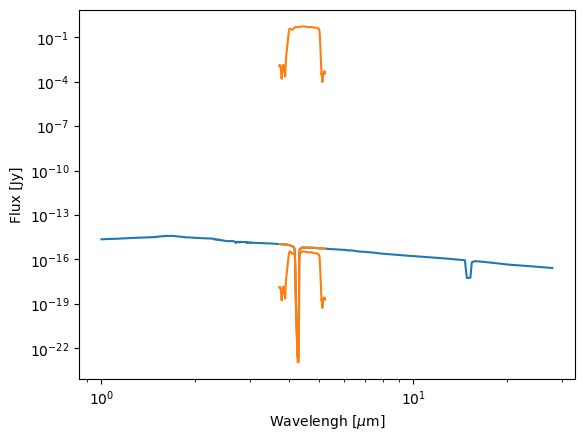

In [28]:
consts = load_molecule('co2')
xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=molecule_data['co2']['molwt'],
                          spectrum=tmods[temperature]['fnu'].quantity,
                          xarr=xarr,
                         )
fluxes_in_one_filter('Spitzer/IRAC.I2', xarr, spec, doplot=True)

In [29]:
for molecule, md in molecule_data.items():
    print(molecule, md)

ch3oh {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/ch3oh-a-Gerakines2020.txt', 'molwt': <Quantity 32. u>}
co2 {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/co2-a-Gerakines2020.txt', 'molwt': <Quantity 44. u>}
co {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/co-a-Palumbo2006.txt', 'molwt': <Quantity 28. u>}
h2o {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/h2o-a-Hudgins1993.txt', 'molwt': <Quantity 18. u>}


In [30]:
molecule_data['co2']

{'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/co2-a-Gerakines2020.txt',
 'molwt': <Quantity 44. u>}